preprocessing

In [ ]:
# data processing 
import pandas as pd
import numpy as np
import re
import random
from collections import Counter
import gensim

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

In [ ]:
!nvidia-smi #-lms 2000

Tue Dec 15 00:47:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data = pd.read_csv('DGA_dataset_labeling.csv')

In [ ]:
data['0(legit) / 1(dga)'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0(legit) / 1(dga), dtype: float64

In [ ]:
data.shape

(1048575, 2)

In [ ]:
len(data['Domain Name'])

1048575

In [ ]:
data.columns

Index(['0(legit) / 1(dga)', 'Domain Name'], dtype='object')

In [ ]:
# target 확인  
data['0(legit) / 1(dga)'].value_counts()

0    1000000
1      48575
Name: 0(legit) / 1(dga), dtype: int64

In [ ]:
# clean data
def cleanData(word):

  word = re.sub(r'[^A-Za-z0-9\s.]', r'', str(word).lower())
  word = re.sub(r'-', r'', word) 

  return word

In [ ]:
data['Domain Name'] = data['Domain Name'].map(lambda x : cleanData(x))  

In [ ]:
data['Domain Name'] # 불용어 제거 필요없음 

0              google.com
1           microsoft.com
2          www.google.com
3             netflix.com
4            facebook.com
                ...      
1048570        keiood.com
1048571        iideld.com
1048572        efmeev.com
1048573        kiyfya.com
1048574        jkhphk.com
Name: Domain Name, Length: 1048575, dtype: object

get weight vector methods1 : word2Vec

In [ ]:
# tokenize domain name : legit 
def delimiter(data_df):
  split_data_list = list()

  for i in range(len(data['Domain Name'])):
    ## true값에 대해서만 워드사전 임베딩 
    if data['0(legit) / 1(dga)'][i] == 0:
      split_data = data_df['Domain Name'][i].split('.')
      split_data_list.append(split_data)

  return split_data_list

In [ ]:
split_data_list = delimiter(data) # tokenize단위가 각 sentence

In [ ]:
print(split_data_list[:10]) # 각 setnece별로 리스트 확인 가능 

[['google', 'com'], ['microsoft', 'com'], ['www', 'google', 'com'], ['netflix', 'com'], ['facebook', 'com'], ['ftl', 'netflix', 'com'], ['prod', 'ftl', 'netflix', 'com'], ['apiglobal', 'netflix', 'com'], ['nrdp', 'prod', 'ftl', 'netflix', 'com'], ['windowsupdate', 'com']]


In [ ]:
import gensim
gensim.__version__ # gensim version check 

'3.6.0'

In [ ]:
from gensim.models import word2vec

In [ ]:
## parameters
num_features = 256  # Word vector dimensionality
min_word_count = 3  # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

## word2vec : skip-gram 
model = word2vec.Word2Vec(split_data_list, workers = num_workers, size = num_features, min_count = min_word_count, window = context, sample = downsampling) 
model.init_sims(replace = True)

In [ ]:
## word2vec : skipgram + 전체 워드사전
model_allwords = word2vec.Word2Vec(split_data_list, workers = num_workers, size = num_features, min_count = min_word_count, window = context, sample = downsampling)
model_allwords.init_sims(replace = True)

In [ ]:
## word2vec : CBOW
oversampling = 1e-3

model_CBOW = word2vec.Word2Vec(split_data_list, workers=num_workers, size = num_features, min_count= min_word_count, window = context, sample = oversampling, sg = 0)
model_CBOW.init_sims(replace = True)

In [ ]:
### skipgram 가중치 
filename = 'embedding_legit_data_skipgram.txt'
model.wv.save_word2vec_format(filename, binary = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
### skipgram 가중치 + 전체 워드 사전 
filename2 = 'embedding_all_data_skipgram.txt'
model_allwords.wv.save_word2vec_format(filename2, binary= False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
### cbow 가중치 
filename3 = 'embedding_legit_data_cbow.txt'
model_CBOW.wv.save_word2vec_format(filename3, binary = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
weight_embedding = model.wv.vectors
vocab_size, embedding_size = weight_embedding.shape
print(vocab_size)
print(embedding_size)

68377
256


In [ ]:
weight_embedding_cbow = model_CBOW.wv.vectors
vocab_size, embedding_size = weight_embedding.shape
print(vocab_size)
print(embedding_size)

68377
256


In [ ]:
weight_embedding.shape

(68377, 256)

In [ ]:
model.wv.most_similar("google") ## check model 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('googleusercontent', 0.7580836415290833),
 ('youtube', 0.7501130700111389),
 ('intel', 0.7086676955223083),
 ('googleapis', 0.6985816359519958),
 ('linkedin', 0.6850776672363281),
 ('iccomponents', 0.6778532266616821),
 ('indeed', 0.677353024482727),
 ('yicelectronics', 0.6716306209564209),
 ('pinterest', 0.6697263121604919),
 ('pswec', 0.6686169505119324)]

In [ ]:
# 고정벡터 변환
def featureVecMethods(words, model, num_features):
  vector_list = list()
  featureVec = np.zeros(num_features, dtype = "float32")
  nwords = 0

  index2word_set = set(model.wv.index2word) # 워드사전 중복제거 

  for word in words:
    if word in index2word_set:
      nwords = nwords +1
      featureVec = np.add(featureVec, model[word])

  featureVec = np.divide(featureVec, nwords)

  return featureVec, nwords


# 각 feature vector의 average 
def getAvgFeatureVecs(words, model, num_features):
  domainFeatureVecs = np.zeros((len(words), num_features), dtype = "float")
  counter = 0
  num_words = 0

  for word in words :
    domainFeatureVecs[counter], nwords = featureVecMethods(word, model, num_features)
    counter += 1
    num_words += nwords

  return domainFeatureVecs, num_words

In [ ]:
#trainDataVecs, num_words = getAvgFeatureVecs(split_data_list, model, num_features) # 고정벡터 평균 

In [ ]:
# weight matrix shape 
print(weight_embedding.shape)
print(weight_embedding)

(68377, 256)
[[ 0.01184468  0.02196977  0.04829109 ...  0.098241    0.0122842
   0.03720398]
 [ 0.09227118 -0.01584603  0.1305353  ... -0.05043395 -0.0653203
   0.07215706]
 [ 0.04901149  0.01781525  0.07647792 ...  0.00467532 -0.08850966
   0.07156074]
 ...
 [ 0.18074854 -0.01106949  0.05546957 ...  0.00621702 -0.08295643
  -0.08950781]
 [ 0.13401593 -0.03279413  0.01649012 ...  0.03919533  0.00708954
  -0.07270698]
 [ 0.01993558  0.07821891  0.01122891 ...  0.00727771 -0.03557441
   0.02347348]]


In [ ]:
print(model.wv.vocab) # legit word dict

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
words = list(model.wv.vocab)
print('vocab size:', len(words))

vocab size: 68377


In [ ]:
words_cbow = list(model_CBOW.wv.vocab)
print('vocab size:', len(words_cbow))

vocab size: 68377


In [ ]:
vocab_size = len(words)

In [ ]:
vocab_size_cbow = len(words_cbow)

In [ ]:
split_data_list[:10]

[['google', 'com'],
 ['microsoft', 'com'],
 ['www', 'google', 'com'],
 ['netflix', 'com'],
 ['facebook', 'com'],
 ['ftl', 'netflix', 'com'],
 ['prod', 'ftl', 'netflix', 'com'],
 ['apiglobal', 'netflix', 'com'],
 ['nrdp', 'prod', 'ftl', 'netflix', 'com'],
 ['windowsupdate', 'com']]

get weight vector methods2 : char2vec / character embedding

In [ ]:
from gensim.models import word2vec

In [ ]:
# 각 sentence에서 char별로 분리
def char_delimiter(data_df):
  split_data_list = list()

  for i in range(len(data['Domain Name'])):
    if data['0(legit) / 1(dga)'][i] == 0:
      split_data = data_df['Domain Name'][i]
      tmp_data_list = list()
      for k in range(len(split_data)):
        tmp_list = list(split_data[k])
        tmp_data_list += tmp_list
      
      split_data_list.append(tmp_data_list)

  return split_data_list

In [ ]:
split_char_list = char_delimiter(data)

In [ ]:
split_char_list[:3]

[['g', 'o', 'o', 'g', 'l', 'e', '.', 'c', 'o', 'm'],
 ['m', 'i', 'c', 'r', 'o', 's', 'o', 'f', 't', '.', 'c', 'o', 'm'],
 ['w', 'w', 'w', '.', 'g', 'o', 'o', 'g', 'l', 'e', '.', 'c', 'o', 'm']]

In [ ]:
# 각 char을 ascii로 변환 
## character embedding을 위함 
def char_to_ascii(split_char_list):

  for i in range(len(split_char_list)):
    for k in range(len(split_char_list[i])):
      split_char_list[i][k] = str(ord(split_char_list[i][k]))
      if split_char_list[i][k] == None :
        ## not contain in ascii, convert 128
        split_char_list[i][k] = '128'

  return split_char_list

In [ ]:
ascii_list = char_to_ascii(split_char_list)  

In [ ]:
ascii_arr = np.array(ascii_list)

In [ ]:
# 가중치 벡터 형태로 변형 (ascii 변환 안한상태 )
## parametersTokenizer
num_features = 256  # Word vector dimensionality
min_word_count = 3  # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
oversampling = 1e-3 # (0.001) Downsample setting for frequent words

## char2vec : skip-gram 
model_char = word2vec.Word2Vec(split_char_list, workers = num_workers, size = num_features, min_count = min_word_count, window = context, sample = oversampling)
model_char.init_sims(replace = True)

In [ ]:
print(model_char.wv.vocab) # legit word dict

{'g': <gensim.models.keyedvectors.Vocab object at 0x7f9d0e9a3438>, 'o': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd1d0>, 'l': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd828>, 'e': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bdf28>, '.': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd0b8>, 'c': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd128>, 'm': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bdef0>, 'i': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd3c8>, 'r': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd208>, 's': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd4a8>, 'f': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd7f0>, 't': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bdb00>, 'w': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd9e8>, 'n': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd240>, 'x': <gensim.models.keyedvectors.Vocab object at 0x7f9cb88bd048>, 'a': <gen

In [ ]:
words = list(model_char.wv.vocab)
print(words)
print('vocab size:', len(words))

['g', 'o', 'l', 'e', '.', 'c', 'm', 'i', 'r', 's', 'f', 't', 'w', 'n', 'x', 'a', 'b', 'k', 'p', 'd', '-', 'u', 'h', 'y', 'v', '4', '1', '0', 'q', '2', '3', 'z', '9', '6', '5', '8', '7', 'j', 'E', '#', 'N', 'A', 'M', '?']
vocab size: 44


In [ ]:
weight_embedding = model_char.wv.vectors
vocab_size, embedding_size = weight_embedding.shape
print(vocab_size)
print(embedding_size)

44
256


In [ ]:
# char2vec model 저장 
filename_char = 'embedding_char_data.txt'
model_char.wv.save_word2vec_format(filename_char, binary= False)

model data input shape

In [ ]:
# train,test값 shuffle 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['Domain Name'], data['0(legit) / 1(dga)'],test_size = 0.3,  shuffle = True)

In [ ]:
X_train.index[0]

628221

In [ ]:
y_train.value_counts() # 불균형 

0    700011
1     33991
Name: 0(legit) / 1(dga), dtype: int64

In [ ]:
y_test.value_counts() # 불균형 

0    299989
1     14584
Name: 0(legit) / 1(dga), dtype: int64

In [ ]:
# weight vector from pretrained word2vec model 
import os

embeddings_index = {}

f = open(os.path.join('', filename), encoding = "utf-8")  

for line in f :
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs

f.close()

In [ ]:
# cbow가중치 벡터
import os

embeddings_index_cbow = {}

f = open(os.path.join('', filename3), encoding = "utf-8")

for line in f :
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index_cbow[word] = coefs

f.close()

In [ ]:
# char2vec 가중치 벡터 
import os

filename_char = 'embedding_char_data.txt'
embeddings_index_char = {}

f = open(os.path.join('', filename_char), encoding = "utf-8") 

for line in f :
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index_char[word] = coefs

f.close()

In [ ]:
# input, output shape check 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [ ]:
# word2vec
## tokenize
tokenizer_obj = Tokenizer()
total_domain = data['Domain Name'].values
domain_train = X_train.values
domain_test = X_test.values
tokenizer_obj.fit_on_texts(domain_train) 

## train sequences
word_index = tokenizer_obj.word_index
vocab_size = len(tokenizer_obj.word_index) + 1
max_length = max([len(s.split('.')) for s in domain_train])
sequences = tokenizer_obj.texts_to_sequences(domain_train)

## final data 
domain_pad = pad_sequences(sequences , maxlen = max_length)
target_train = y_train.values

In [ ]:
# char2vec
## tokenize 
tokenizer_obj = Tokenizer(char_level = True)
total_domain = data['Domain Name'].values
domain_train = X_train.values
domain_test = X_test.values
tokenizer_obj.fit_on_texts(domain_train)

## train sequences
word_index = tokenizer_obj.word_index
vocab_size = len(tokenizer_obj.word_index) + 1
sequences = tokenizer_obj.texts_to_sequences(domain_train)

## max_len 조정하기 
max_length = max([len(s) for s in sequences])

## final data 
domain_pad = pad_sequences(sequences , maxlen = max_length)
target_train = y_train.values

In [ ]:
print(max_length)

248


In [ ]:
X_train

294489            f7.w160.photo.talk.zdn.vn
875727                 bookkeeper.playq.net
500542                          seisint.com
450054           58cdn.com.cn.cdn.dnsv1.com
540243                             gmed.com
                        ...                
318231                      coffeeordie.com
511782    download.alicdn.com.itotolink.net
279747                    imprd.g-tvapp.com
934850                   mail.solopress.com
47598                 ytimg.com.domain.name
Name: Domain Name, Length: 734002, dtype: object

In [ ]:
print(domain_pad.shape)
print(target_train.shape)

(734002, 248)
(734002,)


In [ ]:
# character embedding  
## tokenize 
tokenizer_obj = Tokenizer(char_level = True)
total_domain = data['Domain Name'].values
domain_train = X_train.values
domain_test = X_test.values

# 같은방식으로 embedding
split_data_list = list()

for i in range(domain_train.shape[0]):
  split_data = domain_train[i]
  tmp_data_list = list()
  for k in range(len(split_data)):
    tmp_list = list(split_data[k])
    tmp_data_list += tmp_list
  split_data_list.append(tmp_data_list)

sequences = split_data_list 

# ascii 변환 
sequences = char_to_ascii(sequences) 
max_length = max([len(s) for s in sequences])

## final data 
domain_pad = pad_sequences(sequences , maxlen = max_length)
target_train = y_train.values

In [ ]:
tokenizer_obj.fit_

In [ ]:
print(max_length)

248


In [ ]:
print(domain_pad.shape)
print(target_train.shape)

In [ ]:
# downsampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 0)
rus.fit(domain_pad, target_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


RandomUnderSampler(random_state=0, ratio=None, replacement=False,
                   return_indices=False, sampling_strategy='auto')

In [ ]:
tmp_idx = 0
test_indx = X_train.index[tmp_idx]

print(domain_pad[tmp_idx])
print(X_train[test_indx])

count = 0
for i in range(len(domain_pad[tmp_idx])):
  if domain_pad[tmp_idx][i] != 0:
    count += 1
#print(count)
#print(len(X_train[test_indx]))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  3 11 22  3 11 17
 37  1 30 13 37  1 11 16]
server-8.0d8.ru


In [ ]:
domain_pad_resampled_under, target_train_resampled_under = rus.fit_resample(domain_pad, target_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
domain_pad_resampled_under.shape 

(67982, 248)

In [ ]:
print(pd.DataFrame(target_train_resampled_under).value_counts()) # undersampling data target
print(pd.DataFrame(target_train).value_counts())                 # default data target

1    33991
0    33991
dtype: int64
0    700011
1     33991
dtype: int64


In [ ]:
# oversampling : SMOTE
from imblearn.over_sampling import SMOTE

oversample_smote = SMOTE()
oversample_smote.fit(domain_pad, target_train)

domain_pad_resampled, target_train_resampled = oversample_smote.fit_resample(domain_pad, target_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.DataFrame(target_train_resampled).value_counts() # smote data target 

1    699777
0    699777
dtype: int64

In [ ]:
print(domain_pad_resampled.shape) 
print(target_train_resampled.shape)

(1399554, 248)
(1399554,)


In [ ]:
# test sequence
## word2vec, char2vec
sequences_test = tokenizer_obj.texts_to_sequences(domain_test)
domain_pad_test = pad_sequences(sequences_test, maxlen = max_length)
target_test = y_test.values

In [ ]:
# domain_test에 대해 tokenize진행 
## input은 이미 .단위로 tokenize된 형태여야 한다. 
def test_char_delimiter(test_data):
  split_data_list = list()

  for i in range(test_data.shape[0]):
    split_data = test_data[i].split('.')
    split_data_list.append(split_data)

  return split_data_list

def test_data_spliter(test_data):
  split_data_list = list()

  for i in range(len(test_data)):
    split_data = test_data[i]
    tmp_data_list = list()
    for k in range(len(split_data)):
      tmp_list = list(split_data[k])
      tmp_data_list += tmp_list
    split_data_list.append(split_data)

  return split_data_list

# split된 형태 사용 
splitted_word_test = test_char_delimiter(domain_test)
splitted_char_test = test_data_spliter(splitted_word_test)

In [ ]:
## check
#splitted_char_test[:2] 

In [ ]:
# test sequences
## ascii 
split_data_list = list()

for i in range(domain_test.shape[0]):
  split_data = domain_test[i]
  tmp_data_list = list()
  for k in range(len(split_data)):
    tmp_list = list(split_data[k])
    tmp_data_list += tmp_list
  split_data_list.append(tmp_data_list)

sequences = split_data_list 

# ascii 변환 
sequences = char_to_ascii(sequences)

sequences_test = sequences
domain_pad_test = pad_sequences(sequences_test, maxlen = max_length)
target_test = y_test.values

In [ ]:
EMBEDDING_DIM = 256
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))


for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word) 
  if embedding_vector is not None :
    embedding_matrix[i] = embedding_vector

In [ ]:
EMBEDDING_DIM = 256
num_words = len(word_index)+1
embedding_matrix_char = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index_char.get(word) 
  if embedding_vector is not None :
    embedding_matrix_char[i] = embedding_vector

In [ ]:
EMBEDDING_DIM = 256
num_words = len(word_index)+1
embedding_matrix_cbow = np.zeros((num_words, EMBEDDING_DIM))


for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index_cbow.get(word)
  if embedding_vector is not None :
    embedding_matrix_cbow[i] = embedding_vector

In [ ]:
print(embedding_matrix_char.shape) 
#print(embedding_matrix.shape)

(41, 256)


In [ ]:
word_index = tokenizer_obj.word_index

In [ ]:
# when using down sampling 
domain_pad_resampled =domain_pad_resampled_under
target_train_resampled = target_train_resampled_under

In [ ]:
# save processed data 
import numpy as np

np.save('./X_train_char2vec', domain_pad_resampled)
np.save('./X_test_char2vec', target_train_resampled)
np.save('./y_train_char2vec',domain_pad_test)
np.save('./y_test_char2vec', target_test)

In [ ]:
# save embedding layer with pretrained weight 
## embedding matrix
np.save('./embedding_matrix_word2vec_char',embedding_matrix_char)

embedding layer with pre-trained methods

In [ ]:
# 이전 데이터 
domain_pad_resampled = np.load("X_train_char2vec.npy") 
target_train_resampled = np.load("X_test_char2vec.npy")

domain_pad_test = np.load("y_train_char2vec.npy")
target_test = np.load("y_test_char2vec.npy")

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import optimizers

bidirectional LSTM

In [ ]:
target_train.shape # with shape 2

(734002,)

In [ ]:
print(domain_pad_resampled.shape)  
print(target_train_resampled.shape)

In [ ]:
# target with the categorical data 
from keras.utils import to_categorical
target_train_recat = to_categorical(target_train_resampled).astype(int)
target_test_tecat = to_categorical(target_test).astype(int)

In [ ]:
print(target_train_recat.shape)
print(target_train.shape)

(67846, 2)
(734002,)


In [ ]:
## test with bidirectional LSTM model with 1 layer 
## char 
model = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_char],
                            input_length = max_length,
                            trainable = False)

model.add(embedding_layer)
model.add((LSTM(units = 32, dropout = 0.2, recurrent_dropout = 0.2)))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid')) # output with two output

In [ ]:
model.predict_proba ## check

<bound method Sequential.predict_proba of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f69362aeac8>>

bidirectional LSTM + attention

In [ ]:
# 1. 
# bidirectional LSTM 2 layer experiment with no pretrained weight matrix 
sequence_input = Input(shape = (max_length,),dtype = 'int32')
embedded_sequences = Embedding(vocab_size, 128, input_length = max_length, mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
# 2. 
# bidirectional LSTM 2 layer experiment with pretrained weight matrix
sequence_input = Input(shape = (max_length,),dtype = 'int32')
embedded_sequences = Embedding(num_words,256, input_length = max_length, 
                               weights = [embedding_matrix_char], mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [ ]:
# shape check
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)
print(max_length)

(None, 248, 128) (None, 64) (None, 64) (None, 64) (None, 64)
248


In [ ]:
# attention class 
import tensorflow as tf
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): 
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

# LSTM에 attention concat 
attention = BahdanauAttention(64) # 가중치 크기 정의 
context_vector, attention_weights = attention(lstm, state_h)

In [ ]:
dense1 = Dense(32, activation="relu")(context_vector)
dropout = Dropout(0.3)(dense1)
#output = Dense(1, activation="sigmoid")(dropout)
output = Dense(2, activation='sigmoid')(dropout)
model = Model(inputs = sequence_input, outputs = output)

In [ ]:
# compile
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'mse'])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 248, 256)          10496     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36992     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 47,554
Trainable params: 37,058
Non-trainable params: 10,496
_________________________________________________________________


In [ ]:
print('Train...')
model.fit(domain_pad_resampled, target_train_recat,
          batch_size=800,
          epochs=1)

Train...
133/133 [==============================] - 112s 846ms/step - loss: 0.3859 - accuracy: 0.8217


In [ ]:
model.summary() # bidirectional LSTM with attention 

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 248)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 248, 256)     10496       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 248, 128)     164352      embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) [(None, 248, 128), ( 98816       bidirectional_6[0][0]            
_______________________________________________________________________________________

In [ ]:
#domain_pad_resampled = domain_pad_resampled_under
#target_train_resampled = target_train_resampled_under

In [ ]:
print(domain_pad_resampled.shape)
print(target_train_resampled.shape)
print(target_train_recat.shape)

(1400088, 248)
(1400088,)
(1400088, 2)


In [ ]:
#print(target_train_recat) # to target to the categorical data 
#print(target_test_tecat)

In [ ]:
# check data 
print(target_train_recat.shape)
print(len(domain_pad_resampled))
print(target_test_tecat.shape)
print(len(domain_pad_test))

# output layer check 
print(target_train_resampled[0])
print(target_train_recat[0])

(1400088, 2)
1400088
(314573, 2)
314573
0
[1 0]


In [ ]:
model.predict()

In [ ]:
def keras_model(embedding_matrix_char, X_train, X_test, target_train, target_test):
  ## data shape
  target_train_recat = to_categorical(target_train).astype(int)
  target_test_tecat = to_categorical(target_test).astype(int)

  ## length check
  print(target_train_recat.shape)
  print(target_test_tecat.shape)
  print(len(X_train))
  print(len(X_test))

  sequence_input = Input(shape = (max_length,), dtype = 'int32')
  embedded_sequences = Embedding(num_words, 256, input_length = max_length,weights = [embedding_matrix_char],mask_zero = True)(sequence_input)
  lstm = Bidirectional(LSTM(64,
                            dropout=0.5,
                            return_sequences=True))(embedded_sequences)
  lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

  state_h = Concatenate()([forward_h, backward_h])
  #state_c = Concatenate()([forward_c, backward_c])

  # bi-LSTM에 attention concat
  attention = BahdanauAttention(64)
  context_vector, attention_weights = attention(lstm, state_h)

  dense1 = Dense(32, activation="relu")(context_vector)
  dropout = Dropout(0.3)(dense1)
  #output = Dense(1, activation="sigmoid")(dropout)
  output = Dense(2, activation="sigmoid")(dropout)
  model = Model(inputs = sequence_input, outputs = output)

  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy','mse'])
  #history = model.fit(X_train, target_train_recat, epochs = 1, batch_size = 256, validation_data=(X_test, target_test_tecat), verbose=1)
  model.fit(X_train, target_train_recat, epochs = 1, batch_size = 256, validation_data=(X_test, target_test_tecat), verbose=1)

  return model

In [ ]:
#trained_models_keras_mod = keras_model(embedding_matrix_char, domain_pad_resampled, domain_pad_test, target_train_resampled, target_test)  

In [ ]:
##### without function
## data shape
target_train_recat = to_categorical(target_train_resampled).astype(int)
target_test_tecat = to_categorical(target_test).astype(int)


sequence_input = Input(shape = (max_length,), dtype = 'int32')
embedded_sequences = Embedding(num_words, 256, input_length = max_length,weights = [embedding_matrix_char],mask_zero = True)(sequence_input)
lstm = Bidirectional(LSTM(64,
                          dropout=0.5,
                          return_sequences=True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h])
#state_c = Concatenate()([forward_c, backward_c])

# bi-LSTM에 attention concat
attention = BahdanauAttention(64)
context_vector, attention_weights = attention(lstm, state_h)

dense1 = Dense(32, activation="relu")(context_vector)
dropout = Dropout(0.3)(dense1)
output = Dense(2, activation="sigmoid")(dropout)
model = Model(inputs = sequence_input, outputs = output)

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy','mse'])
#history = model.fit(X_train, target_train_recat, epochs = 1, batch_size = 256, validation_data=(X_test, target_test_tecat), verbose=1)
model.fit(domain_pad_resampled, target_train_recat, epochs = 1, batch_size = 256, validation_data=(domain_pad_test, target_test_tecat), verbose=1)  

In [ ]:
model.save_weights("model_weights")

In [ ]:
# 학습 with pretrained weight matrix
## bi-LSTM with attention   
history = model.fit(domain_pad_resampled, 
                    target_train_resampled, 
                    epochs = 5, 
                    batch_size = 800, 
                    validation_data=(domain_pad_test,target_test),
                    verbose=1)

In [ ]:
## for test 
history = model.fit(domain_pad_resampled, target_train_recat, epochs=1, batch_size = 1000, validation_data = (domain_pad_test, target_test_tecat), verbose = 1) 

In [ ]:
domain_pad_resampled_test = domain_pad_resampled[:500]
print(len(domain_pad_resampled_test))

500


In [ ]:
print(target_train_recat)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
target_train_recat_

In [ ]:
# 정답과 확인해서 틀린경우, 맞은 경우 인덱스 저장해서 확인 
pred_not_idx = list()
pred_corrext_idx =list()

## target_Train_recat_pred와 target_train_recat값 비교 
print(len(target_Train_recat_pred))
print(len(target_train_recat))

for i in range(len(target_train_recat)):
  if target_Train_recat_pred[i] == target_train_recat[i]:
    pred_correct_idx.append(i)
  else :
    pred_not_idx.append(i)

## check the index value 
print(pred_not_idx)
print(pred_correct_idx)

In [ ]:
# check predict proba
predict = model.predict_proba(domain_pad_resampled)
print(predict[:10]

Instructions for updating:
Please use `model.predict()` instead.


array([[0.46021178],
       [0.17426847],
       [0.44246346],
       ...,
       [0.78763664],
       [0.46637258],
       [0.44683573]], dtype=float32)

In [ ]:
predict = model.predict(domain_pad_resampled)
print(predict)

In [ ]:
predict

array([[0.49215347, 0.5031084 ],
       [0.49563316, 0.501855  ],
       [0.4944452 , 0.5023991 ],
       ...,
       [0.47931725, 0.5077938 ],
       [0.4813867 , 0.50721115],
       [0.49286318, 0.5025643 ]], dtype=float32)

In [ ]:
# without sigmoid, use predicted prob 
## train값에 대한 predicted prob값 for Lime 
predicted_prob = model.predict(domain_pad_resampled) 
predicted_prob[:10]

In [ ]:
# simple-LSTM train
#history = model.fit(domain_pad_resampled, target_train_resampled, epochs = 4, batch_size = 256, validation_data=(domain_pad_test, target_test), verbose=1 )

In [ ]:
# bi-LSTM predict
score = model.evaluate(domain_pad_test, target_test)

print(score[0]) # acc 
print(score[1]) # mse

In [ ]:
model.save("biLSTM")

In [ ]:
# input shape for ascii LSTM 
domain_pad_resampled = np.reshape(domain_pad_resampled, (domain_pad_resampled.shape[0], 1, domain_pad_resampled.shape[1]))
domain_pad_test = np.reshape(domain_pad_test, (domain_pad_test.shape[0], 1, domain_pad_test.shape[1]))

In [ ]:
domain_pad_resampled.shape

(1400020, 1, 20)

In [ ]:
domain_pad_test.shape

(314573, 1, 20)

In [ ]:
## test with LSTM model 
## ascii 
model = Sequential()
model.add(LSTM(units = 32,input_dim = 241, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
#model.add(Bidirectional(LSTM(units = 32, dropout = 0.2, recurrent_dropout = 0.2))) # bidirectional LSTM 참고 

In [ ]:
## test with LSTM model with cbow weight 
model_cbow = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix], 
                            input_length = max_length,
                            trainable = False)

model_cbow.add(embedding_layer)
model_cbow.add(LSTM(units = 32, dropout = 0.3, recurrent_dropout = 0.3))
model_cbow.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model_cbow.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 256)           9728      
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36992     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 46,753
Trainable params: 37,025
Non-trainable params: 9,728
_________________________________________________________________


In [ ]:
#model_cbow.summary()

In [ ]:
print(target_train_resampled.shape)  
print(domain_pad_resampled.shape)
print(max_length)

(1399976,)
(1399976, 20)
20


In [ ]:
domain_pad_resampled.shape # feature data 

(1399976, 1, 20)

In [ ]:
target_train_resampled.shape # target data

(1500182,)

In [ ]:
# target scaling
#sc = MinMaxScaling(range = (0,1))
#domain_pad_resampled = sc.fit_transform(domain_pad_resampled)
#domain_pad_test = sc.fit_transform(domain_pad_test)

In [ ]:
model.fit(domain_pad_resampled, target_train_resampled, batch_size = 100, epochs = 10) # oversampling

In [ ]:
model_cbow.fit(domain_pad_resampled, target_train_resampled, batch_size = 100, epochs = 10)

In [ ]:
model.fit(domain_pad_resampled_under, target_train_resampled_under, batch_size = 100, epochs = 10) # undersampling

In [ ]:
preds = model.predict(domain_pad_test)
#print(preds)

In [ ]:
model.save("my_model2")

In [ ]:
# bi LSTM + attention with test data 
score = model.evaluate(domain_pad_test, target_test, verbose = 0)
print( score[0] )     # mse
print( score[1] )     # acc score

DNN + random search cv

In [ ]:
# DNN to use random cv
from keras.wrappers.scikit_learn import KerasClassifier
## build model
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout = 1):
  
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    
    # for the firt layer we need to specify the input dimensions
    first=True
    
    for i in range(nl1):
        # embedding layer 
        if first:
            embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_cbow], 
                            input_length = max_length,
                            trainable = False)
            model.add(embedding_layer)
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))
            
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

## model for random cv 
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=20, verbose=1)

In [ ]:
# tuning
from sklearn.model_selection import RandomizedSearchCV, KFold

# learning algorithm parameters
lr=[1e-2, 1e-3, 1e-4]
decay=[1e-6,1e-9,0]

# activation
activation=['relu', 'sigmoid','tanh']

# numbers of layers
nl1 = [0,1,2,3]
nl2 = [0,1,2,3]
nl3 = [0,1,2,3]

# neurons in each layer
nn1=[300,700,1400, 2100]
nn2=[100,400,800]
nn3=[50,150,300]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.01, 0.003, 0.001,0.0001]

# dictionary summary
param_grid = dict(
                    nl1=nl1, nl2=nl2, nl3=nl3, nn1=nn1, nn2=nn2, nn3=nn3,
                    act=activation, l1=l1, l2=l2, lr=lr, decay=decay, dropout=dropout
                 )

grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=param_grid, 
                          verbose=20,  n_iter=10, n_jobs=1)

In [ ]:
import keras

In [ ]:
grid_results = grid.fit(domain_pad_resampled, target_train_resampled) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Layer weight shape (38, 256) not compatible with provided weight shape (426103, 256)

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu, score=nan, total=   0.3s
[CV] nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu 
[CV]  nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu, score=nan, total=   0.1s
[CV] nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu 
[CV]  nn3=150, nn2=800, nn1=1400, nl3=3, nl2=2, nl1=3, lr=0.0001, l2=0.001, l1=0.001, dropout=0.1, decay=0, act=relu, score=nan, total=   0.1s
[CV] nn3=300, nn2=400, nn1=2100, nl3=0, nl2=1, nl1=2, lr=0.01, l2=0.01, l1=0.001, dropout=0, decay=0, act=sigmoid 
[CV]  nn3=300, nn2=400, nn1=2100, nl3=0, nl2=1, nl1=2, lr=0.01, l2=0.01, l1=0.001, dropout=0, decay=0, act=sigmoid, score=nan, total=   0.1s
[CV] nn3=300, nn2=400, nn1=2100, nl3=0, nl2=1, nl1=2, lr=0.01, l2=0.01, l1=0.001,

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  nn3=50, nn2=800, nn1=300, nl3=3, nl2=2, nl1=1, lr=0.01, l2=0.01, l1=0.0001, dropout=0.1, decay=1e-09, act=tanh, score=nan, total=   0.1s
[CV] nn3=50, nn2=800, nn1=300, nl3=3, nl2=2, nl1=1, lr=0.01, l2=0.01, l1=0.0001, dropout=0.1, decay=1e-09, act=tanh 
[CV]  nn3=50, nn2=800, nn1=300, nl3=3, nl2=2, nl1=1, lr=0.01, l2=0.01, l1=0.0001, dropout=0.1, decay=1e-09, act=tanh, score=nan, total=   0.1s
[CV] nn3=50, nn2=800, nn1=300, nl3=3, nl2=2, nl1=1, lr=0.01, l2=0.01, l1=0.0001, dropout=0.1, decay=1e-09, act=tanh 
[CV]  nn3=50, nn2=800, nn1=300, nl3=3, nl2=2, nl1=1, lr=0.01, l2=0.01, l1=0.0001, dropout=0.1, decay=1e-09, act=tanh, score=nan, total=   0.1s
[CV] nn3=300, nn2=100, nn1=700, nl3=1, nl2=2, nl1=0, lr=0.001, l2=0.001, l1=0.01, dropout=0.2, decay=1e-06, act=relu 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s


Epoch 1/6
46666/46666 [==============================] - 103s 2ms/step - loss: 0.6462 - accuracy: 0.7682
Epoch 2/6
46666/46666 [==============================] - 101s 2ms/step - loss: 0.5551 - accuracy: 0.7868
Epoch 3/6
46666/46666 [==============================] - 101s 2ms/step - loss: 0.5435 - accuracy: 0.8010
Epoch 4/6
 2541/46666 [>.............................] - ETA: 1:35 - loss: 0.5391 - accuracy: 0.8005

KeyboardInterrupt: ignored

In [ ]:
# best model predict 
print(grid_result.best_params_)

In [ ]:
grid.predict(grid_result.best_params_)

In [ ]:
## predict with cbow modeling 
preds_cbow = model_cbow.predict_classes(domain_pad_test)

[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]


In [ ]:
## 예측안된 비율 확인 ( class별 확인 ) with skipgram 
count_class1 = 0
count_class0 = 0

for i in range(len(target_test)):
  if target_test[i] != preds[i][0]:
    if target_test[i] == 0 :
      count_class0 += 1
    elif target_test[i] == 1:
      count_class1 += 1

print('class1 예측 x ratio: ', count_class1 /len(target_test[target_test == 1]) )
print('class0 예측 x ratio: ', count_class0 /len(target_test[target_test == 0]) )

class1 예측 x ratio:  0.05226289403200329
class0 예측 x ratio:  0.030528778848846045


In [ ]:
## 예측안된 비율 확인 ( class별 확인 ) with skipgram 
## cbow 
count_class1 = 0
count_class0 = 0

for i in range(len(target_test)):
  if target_test[i] != preds_cbow[i][0]:
    if target_test[i] == 0 :
      count_class0 += 1
    elif target_test[i] == 1:
      count_class1 += 1

print('class1 예측 x ratio: ', count_class1 /len(target_test[target_test == 1]) )
print('class0 예측 x ratio: ', count_class0 /len(target_test[target_test == 0]) )

class1 예측 x ratio:  0.010788720882713527
class0 예측 x ratio:  0.2101084794865331


In [ ]:
## test score : skip gram 
score = model.evaluate(domain_pad_test, target_test, verbose = 0)
print( score[0] )     # mse
print( score[1] )     # acc score

0.0704621970653534
0.9684652090072632


In [ ]:
## test score : cbow
score_cbow = model_cbow.evaluate(domain_pad_test, target_test, verbose = 0)
print( score_cbow[0] ) # mse
print( score_cbow[1] ) # acc score 

0.29417991638183594
0.7991943359375


RNN

In [ ]:
## char2vec model with simple rnn 
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential() 

## input embedding vector with skipgram embedding model 
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_char],
                            input_length = max_length,
                            trainable = False)

model_rnn.add(embedding_layer)
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1, activation = 'sigmoid'))

# compile rnn cbow model 
model_rnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['mae', 'acc'])
#model_rnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential()

## input embedding vector with skipgram embedding model 
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)
model_rnn.add()
model_rnn.add(SimpleRNN(32))
model_rnn.add(Dense(1, activation = 'sigmoid'))

# compile rnn cbow model 
model_rnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
max_length

50

In [ ]:
model_rnn_cbow = Sequential()

## input embedding vector with cbow embedding model 
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_cbow], 
                            input_length = max_length,
                            trainable = False)

model_rnn_cbow.add(embedding_layer)
model_rnn_cbow.add(SimpleRNN(32))
model_rnn_cbow.add(Dense(1, activation = 'sigmoid'))

# compile rnn cbow 
model_rnn_cbow.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
## skip gram rnn model train 
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)

model_rnn.fit(domain_pad_resampled, target_train_resampled, batch_size = 256, validation_data=(domain_pad_test, target_test), epochs = 10, callbacks=[early_stop]) 

In [ ]:
## rnn model save
model_rnn.save('char_model_rnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: char_model/assets


In [ ]:
## check
reconstructed_model = keras.models.load_model("char_model")

In [ ]:
## cbow rnn model train 
early_stop = EarlyStopping(monitor = 'val_loss', patient = 3, verbose = 1)

model_rnn_cbow.fit(domain_pad_resampled, target_train_resampled, batch_size = 20, epochs = 10, call_backs = [early_stop])

In [ ]:
## predict값 확인 
preds_rnn = model_rnn.predict_classes(domain_pad_test)
#preds_rnn_cbow = model_rnn_cbow.predict_classes(domain_pad_test)

#print(preds_rnn)
#print(preds_rnn_cbow)

In [ ]:
## 예측안된 비율 확인 ( class별 확인 )
count_class1 = 0
count_class0 = 0

for i in range(len(target_test)):
  if target_test[i] != preds_rnn[i][0]:
    if target_test[i] == 0 :
      count_class0 += 1
    elif target_test[i] == 1:
      count_class1 += 1

print('class1 예측 x ratio: ', count_class1 /len(target_test[target_test == 1]) )
print('class0 예측 x ratio: ', count_class0 /len(target_test[target_test == 0]) )

class1 예측 x ratio:  0.03385756472769727
class0 예측 x ratio:  0.04260496246816794


In [ ]:
## test score with skipgram 
score = model_rnn.evaluate(domain_pad_test, target_test, verbose = 0)
print( score[0] )     # mse
print( score[1] )     # acc score 80 

0.10499884188175201
0.9577999114990234


DNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras

In [ ]:
model_dnn = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)

model_dnn.add(embedding_layer)
model_dnn.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model_dnn_cbow = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_cbow],
                            input_length = max_length,
                            trainable = False)

model_dnn_cbow.add(embedding_layer)
model_dnn_cbow.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model_dnn_cbow.add(Dropout(0.3))
model_dnn_cbow.add(Dense(1, activation = 'sigmoid'))

In [ ]:
## learning rate control 
#from keras.optimizers import SGD
#opt = SGD(lr = 0.05)

In [ ]:
# compile
model_dnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_dnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 256)           114134016 
_________________________________________________________________
dense_17 (Dense)             (None, 20, 16)            4112      
_________________________________________________________________
dense_18 (Dense)             (None, 20, 1)             17        
Total params: 114,138,145
Trainable params: 4,129
Non-trainable params: 114,134,016
_________________________________________________________________


In [ ]:
model_dnn_cbow.summary()

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

model_dnn.fit(domain_pad_resampled, target_train_resampled, batch_size=15, epochs=10, callbacks=[early_stop]) 

In [ ]:
## predict값 확인 
preds_dnn = model_dnn.predict_classes(domain_pad_test)

In [ ]:
print(preds_dnn.shape)
print(target_test.shape)

(262144, 20, 1)
(262144,)


In [ ]:
## test score 
score = model_dnn.evaluate(domain_pad_test, target_test, verbose = 0)
print( score[0] )     # mse
print( score[1] )     # acc score 

0.6859713196754456
0.14877371490001678


CNN

In [ ]:
embedding_matrix.shape

(426103, 256)

In [ ]:
from keras.layers import Reshape, Conv2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout
from keras import optimizers

In [ ]:
model_cnn = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)

model_cnn.add(embedding_layer)
model_cnn.add(Reshape((max_length, EMBEDDING_DIM,1), input_shape = (max_length, EMBEDDING_DIM)))
model_cnn.add(Conv2D(filters = 30, kernel_size = (5, EMBEDDING_DIM), strides = (1,1), padding = 'valid'))
model_cnn.add(GlobalMaxPooling2D())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dense(1, activation = 'sigmoid'))

In [ ]:
## cnn model with cbow 
model_cnn_cbow = Sequential()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix_cbow],
                            input_length = max_length,
                            trainable = False)

model_cnn_cbow.add(embedding_layer)
model_cnn_cbow.add(Reshape((max_length, EMBEDDING_DIM,1), input_shape = (max_length, EMBEDDING_DIM)))
model_cnn_cbow.add(Conv2D(filters = 30, kernel_size = (5, EMBEDDING_DIM), strides = (1,1), padding = 'valid'))
model_cnn_cbow.add(GlobalMaxPooling2D())
model_cnn_cbow.add(Dense(10, activation='relu'))
model_cnn_cbow.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# for random search cv 
def create_cnn():
  model_cnn = Sequential()
  embedding_layer = Embedding(num_words,
                              EMBEDDING_DIM,
                              weights = [embedding_matrix],
                              input_length = max_length,
                              trainable = False)

  model_cnn.add(embedding_layer)
  model_cnn.add(Reshape((max_length, EMBEDDING_DIM,1), input_shape = (max_length, EMBEDDING_DIM)))
  model_cnn.add(Conv2D(filters = 30, kernel_size = (5, EMBEDDING_DIM), strides = (1,1), padding = 'valid'))
  model_cnn.add(GlobalMaxPooling2D())
  model_cnn.add(Dense(32, activation='relu'))
  model_cnn.add(Dense(1, activation = 'sigmoid'))
  # compile
  model_cnn.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

  return model_cnn


from sklearn.model_selection import RandomizedSearchCV, KFold

# learning algorithm parameters
lr=[1e-2, 1e-3, 1e-4]
decay=[1e-6,1e-9,0]

# activation
activation=['relu', 'sigmoid','tanh']

# numbers of layers
nl1 = [0,1,2,3]
nl2 = [0,1,2,3]
nl3 = [0,1,2,3]

# neurons in each layer
nn1=[300,700,1400, 2100,]
nn2=[100,400,800]
nn3=[50,150,300]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.01, 0.003, 0.001,0.0001]

# dictionary summary
param_grid = dict(
                    nl1=nl1, nl2=nl2, nl3=nl3, nn1=nn1, #nn2=nn2, #nn3=nn3,
                    act=activation, l1=l1, l2=l2, lr=lr, decay=decay, dropout=dropout
                 )

In [ ]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn, epochs=6, batch_size=20, verbose=1)

In [ ]:
grid = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=param_grid, 
                          verbose=20,  n_iter=10, n_jobs=1) 

In [ ]:
grid_results = grid.fit(domain_pad_resampled, target_train_resampled)  

In [ ]:
print(num_words)

426103


In [ ]:
model_cnn.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 256)           109082368 
_________________________________________________________________
reshape (Reshape)            (None, 19, 256, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 1, 30)         38430     
_________________________________________________________________
global_max_pooling2d (Global (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 109,121,119
Trainable params: 38,751
Non-trainable params: 109,082,368
___________________________________

In [ ]:
# 학습
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

model_cnn.fit(domain_pad_resampled, target_train_resampled, batch_size=100, epochs=10, callbacks=[early_stop])  

In [ ]:
## predict값 확인 
preds_cnn = model_cnn.predict_classes(domain_pad_test)
#preds_cnn = np.argmax(model.predict(x), axis=-1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
## evaluate
score = model_cnn.evaluate(domain_pad_test, target_test, verbose = 0)
print( score[0] ) # mse
print( score[1] ) # acc

0.31306925415992737
0.8002308011054993


tld 확인
- generate된 tld값은 이미 있는 tld값들을 가져다 씀

In [ ]:
# tokenize domain name : legit 
def check_tld(data_df):
  legit_domain_list = list()
  generate_domain_list = list()

  for i in range(len(data['Domain Name'])):
    split_data = data_df['Domain Name'][i].split('.')

    if data['0(legit) / 1(dga)'][i] == 0:
      legit_domain_list.append(split_data)
    else :
      generate_domain_list.append(split_data)


  return legit_domain_list, generate_domain_list

In [ ]:
def get_predict_prob_fn_of_class(label):
 def rewrapped_predict(strings):
   preds = flatten_predict(strings)[:, np.where(flatten_predict(strings)==label)].reshape(-1,1) 
   ret = np.asarray(np.hstack([(1-preds),preds]))
   return ret 
  return rewrapped_predcit

In [ ]:
legit_domain_list, generate_domain_list = check_tld(data)

In [ ]:
## legit data tld check 
tld_list = list()

for i in range(len(legit_domain_list)):
  idx = len(legit_domain_list[i])
  value = legit_domain_list[i][idx-1]
  tld_list.append(value)

In [ ]:
pd.DataFrame(tld_list).value_counts()

com          560408
net          131135
org           44248
cn            16804
ru            12641
              ...  
melbourne         1
mb                1
mall              1
mail              1
lh                1
Length: 1699, dtype: int64

In [ ]:
## generate data tld check 
g_tld_list = list()

for i in range(len(generate_domain_list)):
  idx = len(generate_domain_list[i])
  value = generate_domain_list[i][idx-1]
  g_tld_list.append(value)

In [ ]:
pd.DataFrame(g_tld_list).value_counts()

net     12704
com     11607
org      5160
biz      3693
info     2026
        ...  
pm          7
tf          6
yt          6
nl          5
be          3
Length: 62, dtype: int64

In [ ]:
# g_tld_list에 포함된 모든 tld는 tld_list에 이미 있는 값들임  
set(g_tld_list) - set(tld_list) 

set()

test on a new data

In [ ]:
import pandas as pd
import numpy as np

# new test data 
test_data = pd.read_csv('new_test_data.csv')
test_data.head()

,target,Domain Name
0,1,ad92040640643a059a3425b8f3167e22.info
1,1,7c982b5359013faba8d4ade17efa9c34.info
2,1,52d2cd2cc185efb7f9017aef9c2949dd.co.cc
3,1,5317b4c2a27343dfb7f897083e7d7fa1.co.cc
4,1,07c00bbf024d3fdf28e4e9b0f0128fb2.org


In [ ]:
## tokenize 
tokenizer_obj = Tokenizer(char_level = True)
total_test_domain = test_data['Domain Name'].values
for i in range(total_test_domain.shape[0]):
  total_test_domain[i] = str(total_test_domain[i])
tokenizer_obj.fit_on_texts(total_test_domain)

## train sequences
word_index = tokenizer_obj.word_index
vocab_size = len(tokenizer_obj.word_index) + 1
sequences = tokenizer_obj.texts_to_sequences(total_test_domain)
#max_length = max([len(s) for s in sequences])
max_length = 50

## final data 
domain_pad_new_test = pad_sequences(sequences , maxlen = max_length)
target_new_test = test_data['target'].values

In [ ]:
print(domain_pad_new_test.shape)
print(target_new_test.shape)

(2732880, 50)
(2732880,)


In [ ]:
# test data save 
np.save('./domain_pad_new_test', domain_pad_new_test)
np.save('./target_new_test', target_new_test)

In [ ]:
# biLSTM + attention  test result 
score = model.evaluate(domain_pad_new_test, target_new_test, verbose = 0) 

print( score[0] )     # mse
print( score[1] )     # acc score

In [ ]:
# check
#preds = model.predict_classes(pad_domain_new_test)
#print(preds)
model.save("my_model_biLSTM_attention.h5") 

LSTM with best param test

In [ ]:
# 새롭게 generate한 test data로 확인 
score = model.evaluate(domain_pad_new_test, target_new_test, verbose = 0) 
print( score[0] )     # mse
print( score[1] )     # acc score

0.0719580352306366
0.968725860118866


In [ ]:
## simple lstm model save  
model.save("my_model_lstm")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model_lstm/assets


In [ ]:
import keras

In [ ]:
model = keras.models.load_model('/content/my_model.h5')
predictions = np.load('/content/prediction.npy')

**LIME**

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 23.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=5dabf96d63cc1548dddeae9b7a57e699dcc6acba7ccfb5c71de6fe5b53cd0d83
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import time
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import sklearn 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from __future__ import print_function

In [ ]:
X_train

550660    r1---sn-c5oba5apo3-q5js.googlevideo.com
55586                                 iqwfmfi.net
330502                         callblock.cmcm.com
108657                             m26.ccnmbpx.cc
497901                                pages.uc.cn
                           ...                   
791432                            harvardcorp.com
482469                               unataops.com
952434              paesiellos.werknemeroceaan.nl
880755                      citaentertainment.com
669830      mx.mail.protection.partner.outlook.cn
Name: Domain Name, Length: 734002, dtype: object

In [ ]:
## input data vectorization (CountVectorizer)
#vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase = False)
#train_vectors = vectorizer.fit_transform(X_train)
#test_vectors = vectorizer.fit_transform(X_test)

In [ ]:
print(max_length)

248


In [ ]:
## for new training sklearn model 
from sklearn.pipeline import make_pipeline

trained_models = [] #  keep track of all details for models we train

def train_model(model, data, labels, test_data, test_labels):
  pipe = Pipeline([('clf', model["clf"])])
  #pipe = make_pipeline(vectorizer, model["clf"])
  start_time = time.time()
  pipe.fit(data, labels)
  train_time = time.time() - start_time
  
  pred = model["clf"].predict(data)
  train_accuracy =  accuracy_score(labels, pred)

  pred_test = model["clf"].predict(test_data)
  test_accuracy = accuracy_score(test_labels, pred_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  
  return model_details


## learn / predict 
models = [
          {"name": "Naive Bayes" ,"clf": GaussianNB()}]#, 
          #{"name": "logistic regression", "clf": LogisticRegressionCV(max_iter=400)}, 
          #{"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          #{"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          #{"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          #{"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
  model_details = train_model(model, domain_pad_resampled, target_train_resampled, domain_pad_test, target_test) 
  trained_models.append(model_details)
  print(model_details)

{'name': 'Naive Bayes', 'train_accuracy': 0.5102804288912455, 'test_accuracy': 0.0672594278593522, 'train_time': 0.18329930305480957, 'model': Pipeline(memory=None,
         steps=[('clf', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)}


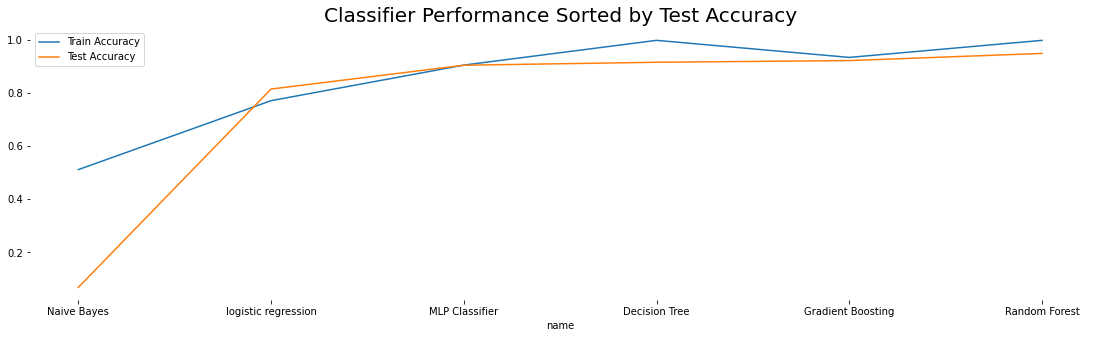

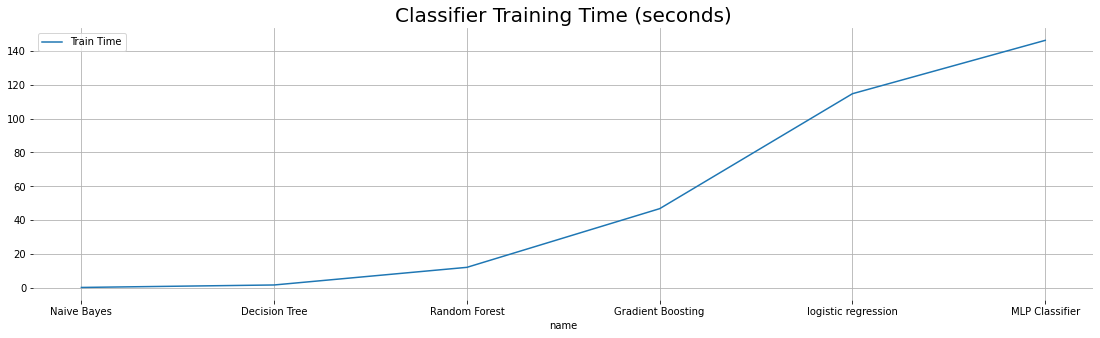

In [ ]:
# visualize accuracy and run time
#setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False) 

In [ ]:
## check train results : overfitting..? how to solve..?
for i in trained_models:
  print(i["name"], i["train_accuracy"], i["test_accuracy"])

logistic regression 0.7714608986980926 0.8140209108855496
Decision Tree 0.9985893555117995 0.9170653552593515
Random Forest 0.9985893555117995 0.9496364913708424
Gradient Boosting 0.9343462544449995 0.9224472538965518
MLP Classifier 0.9053986540100508 0.9048869419816704


In [ ]:
## input shape
#print(X_test[0])
print(split_char_list[0])
#print(current_model["model"]["clf"])
#print(np.reshape([X_train[test_data_index]], (-1,1)))

['g', 'o', 'o', 'g', 'l', 'e', '.', 'c', 'o', 'm']


In [ ]:
from lime.lime_text import LimeTextExplainer

def get_lime_explainer():  
  class_names = ['0(legit)', '1(dga)']
  lime_explainer = LimeTextExplainer(class_names = class_names,
                                     char_level = True,
                                     bow = False 
                                     )
  return lime_explainer

In [ ]:
def lime_explain(explainer, data, predict_method, num_features = 6): 
  #explanation = explainer.explain_instance(data, predict_method, num_features=num_features, labels = [0, 1])
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features)
  #explanation.show_in_notebooks(text = True)
  print(explanation.as_list())
  return explanation

In [ ]:
print(max_length)

248


In [ ]:
# vectorizer define for lime ( require : fit, transform, fit_transform )  

class new_vectorizer(object):
  
  def __init__(self):
    super(new_vectorizer, self).__init__()
    #self.pre_vectorize_data = pre_vectorize_data
  
  def fit(self, raw_data):
    ## for train data : fit
    domain_data = raw_data
    #domain_data = raw_data.values

    tokenize_obj = Tokenizer(char_level = True)
    tokenizer_obj.fit_on_texts(domain_data)
    word_index = tokenizer_obj.word_index
    vacab_size = len(tokenizer_obj.word_index) + 1
    return tokenizer_obj
    
  def transform(self, raw_data):
    ## for train / test data : transform 
    token_obj = self.fit(raw_data)
    max_legth = 248
    sequences_test = token_obj.texts_to_sequences(raw_data)
    domain_pad_test = pad_sequences(sequences_test, maxlen = max_length)

    return domain_pad_test

  def fit_transform(self, raw_data):
    # for train data 
    token_obj = self.fit(raw_data)
    vectorized_data = self.transform(raw_data)
    return vectorized_data


## test on train dataset
new_vectorizer_obj = new_vectorizer() 
#train_vector = new_vectorizer_obj.fit_transform(X_train)
#test_vector = new_vectorizer_obj.fit_transform(X_test)

In [ ]:
X_train.values

array(['dc370.4shared.com', '1oyy2ln1p1zutg134o630hwe4u7.net',
       'www.bsa-logistics.co.id', ...,
       'bwloadbalancer-7804e4198f56b726.elb.ap-southeast-1.amazonaws.com',
       'e9822.x.akamaiedge.net', 'www.holidayseniorliving.com'],
      dtype=object)

In [ ]:
## check
#print(train_vector.shape)
#print(test_vector.shape)
#print(np.array(X_train[9]))

In [ ]:
print(domain_pad_resampled ) # tabular explainer로 확인 

[[ 0  0  0 ... 12 16 19]
 [ 0  0  0 ...  7  3  9]
 [ 0  0  0 ...  2 11 15]
 ...
 [ 0  0  0 ...  1 16 10]
 [ 0  0  0 ...  7  3  9]
 [ 0  0  0 ...  7  3  9]]


In [ ]:
X_train[83]

'pipe.aria.microsoft.com'

In [ ]:
## check
#explanation.as_map()[1]

In [ ]:
print(type(domain_pad_resampled))

<class 'numpy.ndarray'>


In [ ]:
## check predict proba
predict_method.predict_proba([X_train[test_data_index]])

array([[0.98562287, 0.01437713]])

In [ ]:
## 총 5개의 모델에 대해 판단기준 weight print 
from sklearn.pipeline import make_pipeline

lime_data_explainations = []
lime_metrics = []
test_data_index = 83

for current_model in trained_models:
  feat_names = list(X_train[test_data_index])

  predict_method = make_pipeline(new_vectorizer_obj, current_model["model"]["clf"])

  # explain first sample from test data
  lime_explainer = get_lime_explainer()
  explanation = lime_explain(lime_explainer,
                             X_train[test_data_index],
                             #np.reshape([X_train[test_data_index]], (-1,1)),
                             predict_method.predict_proba) 
  
  # save result 
  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex
  
  lime_data_explainations.append(ex_holder) 
  actual_pred = current_model["model"]["clf"].predict_proba(domain_pad_resampled[test_data_index].reshape(1,-1))
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
  #lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
  lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })
 

[('p', 0.0), ('i', 0.0), ('p', 0.0), ('e', 0.0), ('.', 0.0), ('a', 0.0)]


In [ ]:
print(X_train.shape)
X_train_test= X_train[:10]

(734002,)


In [ ]:
X_train_test.shape

(10,)

In [ ]:
## sp-lime func , visualization 
from lime import submodular_pick
def SP_LIME(X_train, trained_models, method, domain_pad = None, new_vectorizer_obj = None, data = None, raw_y = None  ):
  if method == "text":
    tmp_idx = 0 # for domain pad
    test_data_index = X_train.index[tmp_idx]

    for current_model in trained_models:
      feat_names = list(X_train[test_data_index])
      predict_method = make_pipeline(new_vectorizer_obj, current_model["model"]["clf"])
      start_time = time.time()
      lime_explainer = get_lime_explainer()
      sp_obj = submodular_pick.SubmodularPick(lime_explainer, X_train.values, predict_method.predict_proba, num_features = 5, num_exps_desired = 10)
      elapsed_time = time.time() - start_time
      print("SP-LIME execution time : ", elapsed_time)
      #[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]
      [ exp.show_in_notebook() for exp in sp_obj.sp_explanations ]
      ## save the image
      for idx in range(len(fig_list)):
        fig_tmp = fig_list[idx]
        file_name = str(idx) + "sp-lime" + "text"
        fig_tmp.savefig(file_name)

In [ ]:
SP_LIME(X_train_test, trained_models, method = "text", domain_pad = domain_pad, new_vectorizer_obj=new_vectorizer_obj)  

### with keras model 
- 예측이 틀린 idx : pred_not_idx
- 그 중, 어떤 값에 의해 틀린값을 예측했고, 어떤 값에 의해 맞는 값을 예측할 수 있는지를 확인 

In [ ]:
# 예측한값 
pred_result = model.predict(domain_pad_resampled[:100])
pred_result[:5]

array([[6.4328206e-01, 1.7284375e-01],
       [9.6373737e-01, 9.5000200e-05],
       [6.1942530e-01, 1.4556780e-01],
       [1.4632984e-01, 7.8957444e-01],
       [9.2269778e-01, 1.5771129e-03]], dtype=float32)

In [ ]:
pred_result = predictions[:100]
pred_result[:5]

array([[0.80491495, 0.03496462],
       [0.61715764, 0.0893643 ],
       [0.8370965 , 0.03236484],
       [0.745952  , 0.05987247],
       [0.95207566, 0.00641084]], dtype=float32)

In [ ]:
# 실제값
target_train_resampled_test = target_train_resampled[:100]
target_train_resampled_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
target_train_resampled_test = target_test[:100]
target_train_resampled_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(pred_result.shape, target_train_resampled_test.shape) # shape check 

(100, 2) (100,)


In [ ]:
# 맞은값, 틀린값 idx확인 
pred_result_list = list()

for i in range(pred_result.shape[0]):
  if pred_result[i][0] > pred_result[i][1]:
    pred_result_list.append(0)
  else :
    pred_result_list.append(1)


# 틀린 예측 인덱스 tmp_idx_list저장 
tmp_idx_list = list()
tmp_idx_list_cor = list()

for i in range(len(target_train_resampled_test)):
  if target_train_resampled_test[i] != pred_result_list[i]:
    tmp_idx_list.append(i)
  else :
    tmp_idx_list_cor.append(i)

In [ ]:
tmp_idx_list = tmp_idx_list[:50]

In [ ]:
tmp_idx_list_cor = tmp_idx_list_cor[:50]

In [ ]:
# 틀린 index에 대해서 왜 0으로 판단했는지 왜 1로 판단했는지 확인 
from sklearn.pipeline import make_pipeline

predict_method = make_pipeline(new_vectorizer_obj, model)
actual_label = list()
pred_label = list()

value_list = list()
class_0 = list()
class_1 = list()

iter_num = len(tmp_idx_list)

start_time = time.time()
for i in range(iter_num):
  # append value
  print(X_train[X_train.index[tmp_idx_list[i]]]) # 원래 텍스트 값
  value_list.append(X_train[X_train.index[tmp_idx_list[i]]])
  actual_label.append(target_train_resampled_test[tmp_idx_list[i]])
  pred_label.append(pred_result_list[tmp_idx_list[i]])

  # explainer
  lime_explainer = get_lime_explainer()
  explanation = lime_explain(lime_explainer,
                             X_train[X_train.index[tmp_idx_list[i]]],
                             predict_method.predict) 
  #explanation.show_in_notebook()
  
  # 각 인덱스값 확인 
  tmp_0_list = list()
  tmp_1_list = list()

  for feat_idx, value in explanation.as_map()[1]:
    if value < 0 :
      tmp_0_list.append(feat_idx)
    else :
      tmp_1_list.append(feat_idx)
  
  class_0.append(tmp_0_list)
  class_1.append(tmp_1_list)
end_time = time.time() - start_time
print(end_time)

analytics.build.com
[('.', -0.19654291893824752), ('.', -0.056348809587848395), ('y', 0.05080576419064276), ('l', 0.04457835760393611), ('u', 0.03888422142990558), ('b', 0.032718700187818105)]
u8a9.com
[('.', -0.17437792453276224), ('u', 0.08637292958102234), ('a', 0.040792899809235755), ('9', 0.024144570072042338), ('m', 0.018245086167267388), ('o', -0.014696360935615715)]
outmail.b.hostedemail.com
[('.', -0.07368147572134082), ('.', -0.06527727148892454), ('.', -0.021783002924819432), ('b', 0.012427862605004739), ('l', 0.011560925840689873), ('h', 0.008852037264403196)]
v1.lcybgym.ru
[('.', -0.3901295211660171), ('v', 0.1242118149843925), ('y', 0.10018018814417148), ('1', 0.08946662534798235), ('y', 0.07759380355751555), ('.', -0.06365518788299997)]
attack.mitre.org
[('.', -0.05813081843275034), ('.', -0.025802720140878227), ('g', -0.006522987345616681), ('t', -0.006176962497861963), ('k', 0.0059421242956005545), ('i', 0.005715462159215082)]
avofimuxasit.cf
[('v', 0.17162492746563457

In [ ]:
# 각 class별 결과확인 
print(value_list) 
print(actual_label)
print(pred_label)
print(class_0)
print(class_1)

['analytics.build.com', 'u8a9.com', 'outmail.b.hostedemail.com', 'v1.lcybgym.ru', 'attack.mitre.org', 'avofimuxasit.cf', 'msaep.sharepoint.com', 'cdn.waterstones.com', 'mail.smartdrive.com', 'ppuiqh.vkcache.com', 'cdn31481338.ahacdn.me', 'iw-net.com.br', 'bkd.lumajangkab.go.id', 'thegioinem.com', 'broadstreetcap.com', 'learn-about-cf.com', 'www.northerntrust.hscni.net', 'ofgfydq.ru', 'ues598.rol.famatech.com', 'session-21060.ww.np.matching.playstation.net']
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]
[[9, 15, 18], [4, 2, 1, 7, 6], [7, 9, 21], [2, 10, 1, 3, 4, 9], [6, 12, 11, 10, 13, 3], [12, 8, 0, 10, 9], [5, 16, 9, 10, 6, 8], [3, 15, 8, 7, 5, 6], [4, 15, 8, 5, 18], [6, 14, 10, 13, 9, 11], [11, 18, 12, 14, 15, 8], [6, 10, 4], [3, 15], [3, 10], [14], [14, 17, 16], [3, 17, 23, 15, 19], [2, 7, 8], [6, 10, 19, 21, 14], [13, 16, 19, 28, 27]]
[[4, 10, 14], [0], [8, 15, 5], [], [], [1], [], [], [13], [], [], [1, 2, 

In [ ]:
## 전체 데이터프레임으로 변경
tmp_df = [value_list, actual_label, pred_label, class_0, class_1]
df = pd.DataFrame(tmp_df).transpose()
df.head()

df.columns = ['instance','Actual label', 'Pred label', 'class0 Evidence', 'class1 Evidence']
df.to_csv("1210_LIME.csv", index = False)

In [ ]:
df = pd.read_csv("1210_LIME.csv")
df.head()

,instance,Actual label,Pred label,class0 Evidence,class1 Evidence
0,analytics.build.com,0,1,"[9, 15, 18]","[4, 10, 14]"
1,u8a9.com,1,0,"[4, 2, 1, 7, 6]",[0]
2,outmail.b.hostedemail.com,0,1,"[7, 9, 21]","[8, 15, 5]"
3,v1.lcybgym.ru,0,1,"[2, 10, 1, 3, 4, 9]",[]
4,attack.mitre.org,0,1,"[6, 12, 11, 10, 13, 3]",[]


In [ ]:
## 예측값이 정답인 경우에 대해서도 확인해보기 
predict_method = make_pipeline(new_vectorizer_obj, model)
actual_label = list()
pred_label = list()

value_list = list()
class_0 = list()
class_1 = list()

iter_num = len(tmp_idx_list_cor)

for i in range(iter_num):
  # append value
  print(X_train[X_train.index[tmp_idx_list_cor[i]]]) # 원래 텍스트 값
  value_list.append(X_train[X_train.index[tmp_idx_list_cor[i]]])
  actual_label.append(target_train_resampled_test[tmp_idx_list_cor[i]])
  pred_label.append(pred_result_list[tmp_idx_list_cor[i]])

  # explainer
  lime_explainer = get_lime_explainer()
  explanation = lime_explain(lime_explainer,
                             X_train[X_train.index[tmp_idx_list_cor[i]]],
                             predict_method.predict) 
  explanation.show_in_notebook()
  
  # results
  ## index로 확인 
  tmp_0_list = list()
  tmp_1_list = list()

  for feat_idx, value in explanation.as_map()[1]:
    if value < 0 :
      tmp_0_list.append(feat_idx)
    else :
      tmp_1_list.append(feat_idx)
  class_0.append(tmp_0_list)
  class_1.append(tmp_1_list)

In [ ]:
## 전체 데이터프레임으로 변경
tmp_df = [value_list, actual_label, pred_label, class_0, class_1]
df = pd.DataFrame(tmp_df).transpose()
df.head()

df.columns = ['instance', 'Actual label', 'Pred label', 'class0 Evidence', 'class1 Evidence']
df.to_csv("explainer_correct.csv", index = False)

In [ ]:
pd.read_csv("explainer_1203_correct.csv")
df.head()

,instance,Actual label,Pred label,class0 Evidence,class1 Evidence
0,r1---sn-c5oba5apo3-q5js.googlevideo.com,0,0,[],"[9, 2, 18, 15, 21, 23]"
1,iqwfmfi.net,0,0,[],"[1, 3, 0, 2, 4, 5]"
2,callblock.cmcm.com,0,0,[17],"[3, 1, 0, 2, 5]"
3,m26.ccnmbpx.cc,0,0,[],"[3, 2, 1, 4, 0, 6]"
4,pages.uc.cn,0,0,[],"[0, 2, 3, 1, 4, 5]"


### SHAP
- DeepExplainer, GradientExplainer for neural networs
- Kernel Explainer  

In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463912 sha256=ba7a6dca425594b70ea1187b4d52684ce34383be06618183573c80fb4edc74a9
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import shap
def get_kernel_shap_explainer(model, background_data, train_data):  
  shap_explainer = shap.KernelExplainer(model.predict, background_data)   
  return shap_explainer 

In [ ]:
def shap_explain(explainer, test_data): 
  shap_values = explainer.shap_values(test_data, l1_reg="aic")
  return shap_values

In [ ]:
shap_value_list = list()

In [ ]:
import time 

clf = model
sub_sampled_train_data = shap.sample(domain_pad_resampled, 5, random_state=0) # use 600 samples of train data as background data
test_data_index = 0

subsampled_test_data =domain_pad_resampled[test_data_index].reshape(1,-1)
feat_names = list(domain_pad_resampled[test_data_index])

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
shap_value_list.append(shap_values)
elapsed_time = time.time() - start_time

# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
#print("Model mean value", clf.predict(domain_pad_test).mean(axis=0))
#print("Model prediction for test data", clf.predict(subsampled_test_data))


Kernel Explainer SHAP run time 21.819  seconds. 
SHAP expected value [0.24426996 0.6160204 ]


In [ ]:
import time 

clf = model
sub_sampled_train_data = shap.sample(domain_pad_resampled, 5, random_state=0) # use 600 samples of train data as background data
test_data_index = 1

subsampled_test_data =domain_pad_resampled[test_data_index].reshape(1,-1)
feat_names = list(domain_pad_resampled[test_data_index])

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
shap_value_list.append(shap_values)
elapsed_time = time.time() - start_time

# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
#print("Model mean value", clf.predict(domain_pad_test).mean(axis=0))
#print("Model prediction for test data", clf.predict(subsampled_test_data))


Kernel Explainer SHAP run time 21.659  seconds. 
SHAP expected value [0.24426996 0.6160204 ]


In [ ]:
import time 

clf = model
sub_sampled_train_data = shap.sample(domain_pad_resampled, 5, random_state=0) # use 600 samples of train data as background data
test_data_index = 2

subsampled_test_data =domain_pad_resampled[test_data_index].reshape(1,-1)
feat_names = list(domain_pad_resampled[test_data_index])

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
shap_value_list.append(shap_values)
elapsed_time = time.time() - start_time

# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
#print("Model mean value", clf.predict(domain_pad_test).mean(axis=0))
#print("Model prediction for test data", clf.predict(subsampled_test_data))


Kernel Explainer SHAP run time 22.013  seconds. 
SHAP expected value [0.24426996 0.6160204 ]


In [ ]:
import time 

clf = model
sub_sampled_train_data = shap.sample(domain_pad_resampled, 5, random_state=0) # use 600 samples of train data as background data
test_data_index = 3

subsampled_test_data =domain_pad_resampled[test_data_index].reshape(1,-1)
feat_names = list(domain_pad_resampled[test_data_index])

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
shap_value_list.append(shap_values)
elapsed_time = time.time() - start_time

# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
#print("Model mean value", clf.predict(domain_pad_test).mean(axis=0))
#print("Model prediction for test data", clf.predict(subsampled_test_data))


Kernel Explainer SHAP run time 21.813  seconds. 
SHAP expected value [0.24426996 0.6160204 ]


In [ ]:
import time 

clf = model
sub_sampled_train_data = shap.sample(domain_pad_resampled, 5, random_state=0) # use 600 samples of train data as background data
test_data_index = 4

subsampled_test_data =domain_pad_resampled[test_data_index].reshape(1,-1)
feat_names = list(domain_pad_resampled[test_data_index])

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
shap_value_list.append(shap_values)
elapsed_time = time.time() - start_time

# explain first sample from test data
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
#print("Model mean value", clf.predict(domain_pad_test).mean(axis=0))
#print("Model prediction for test data", clf.predict(subsampled_test_data))


Kernel Explainer SHAP run time 21.723  seconds. 
SHAP expected value [0.24426996 0.6160204 ]


In [ ]:
## 출력형태 
class_0_list = list()
class_1_list = list()

for i in range(len(shap_value_list[0])):
  for k in range(len(shap_value_list[0[i])):
    if shap_value_list[0][i][0][k] < 0: 
      class_0_list.append(k)
    elif shap_value_list[0][i][0][k] > 0:
      class_1_list.append(k)
print(class_0_list)

In [ ]:
for i in range(len(feat_names)):
  if type(feat_names[i]) != str :
    feat_names[i] = str(feat_names[i])
print(feat_names)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

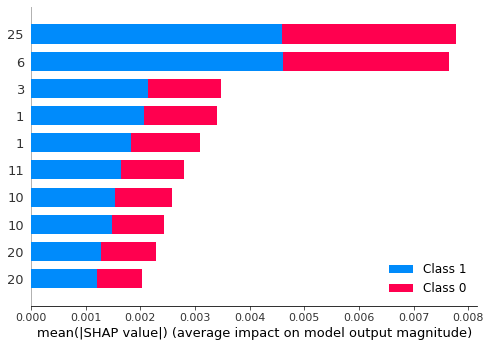

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, subsampled_test_data, feature_names=feat_names, max_display=10)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], subsampled_test_data[0], feature_names=feat_names)

LRP

In [ ]:
# max_legth
print(split_char_list[:2])

[['g', 'o', 'o', 'g', 'l', 'e', '.', 'c', 'o', 'm'], ['m', 'i', 'c', 'r', 'o', 's', 'o', 'f', 't', '.', 'c', 'o', 'm']]


In [ ]:
# 각 list별로 길이 확인
length_list = list()

for i in range(len(split_char_list)):
  length_list.append(len(split_char_list[i]))

In [ ]:
import matplotlib.pyplot as plt
print(pd.DataFrame(length_list).value_counts()) # max_length = 50으로 잡음 ( 뒤에 나머지 hist버림 
#plt.hist(length_list))

15     89028
14     71632
16     61136
13     52019
17     50059
       ...  
111        1
103        1
99         1
97         1
248        1
Length: 129, dtype: int64


In [ ]:
#np.save("domain_pad_test.npy", domain_pad_test)
#np.save("domain_pad_resampled.npy", domain_pad_resampled)
#np.save("X_train.npy", X_train)
#np.save("domain_pad_test.npy", domain_pad_test)
#np.save("target_train.npy", target_train)
#np.save("target_test.npy", target_test)

In [ ]:
np.load("domain_pad_test.npy", domain_pad_test)
np.load("domain_pad_resampled.npy", domain_pad_resampled)
np.load("X_train.npy", X_train)
np.load("domain_pad_test.npy", domain_pad_test)
np.load("target_train.npy", target_train)
np.load("target_test.npy", target_test)

In [ ]:
# visualize in html format
def html_heatmap (words, scores, cmap_name="bwr"):
    colormap  = plt.get_cmap(cmap_name)
     
    #assert len(words)==len(scores)
    max_s     = max(scores)
    min_s     = min(scores)
    
    output_text = ""
    
    for idx, w in enumerate(words):
        score       = rescale_score_by_abs(scores[idx], max_s, min_s)
        output_text = output_text + span_word(w, score, colormap) + " "
    
    return output_text + "\n"

In [ ]:
def rescale_score_by_abs (score, max_score, min_score):
    
    # CASE 1: positive AND negative scores occur
    if max_score>0 and min_score<0:
    
        if max_score >= abs(min_score):   # deepest color is positive
            if score>=0:
                return 0.5 + 0.5*(score/max_score)
            else:
                return 0.5 - 0.5*(abs(score)/max_score)

        else:                             # deepest color is negative
            if score>=0:
                return 0.5 + 0.5*(score/abs(min_score))
            else:
                return 0.5 - 0.5*(score/min_score)   
    
    # CASE 2: ONLY positive scores occur 
    elif max_score>0 and min_score>=0: 
        if max_score == min_score:
            return 1.0
        else:
            return 0.5 + 0.5*(score/max_score)
    
    # CASE 3: ONLY negative scores occur
    elif max_score<=0 and min_score<0: 
        if max_score == min_score:
            return 0.0
        else:
            return 0.5 - 0.5*(score/min_score)
          
#################### heatmap format 

def getRGB (c_tuple):
    return "#%02x%02x%02x"%(int(c_tuple[0]*255), int(c_tuple[1]*255), int(c_tuple[2]*255))

     
def span_word (word, score, colormap):
    return "<span style=\"background-color:"+getRGB(colormap(score))+"\">"+word+"</span>"

In [ ]:
from tensorflow import keras 
model = keras.models.load_model('/content/my_model.h5')

In [ ]:
import numpy as np
predictions = np.load('/content/prediction.npy')

In [ ]:
## with new LSTM 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 248, 256)          10496     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                36992     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 47,554
Trainable params: 37,058
Non-trainable params: 10,496
_________________________________________________________________


In [ ]:
#model.save("my_model.h5")
#np.save("prediction.npy", predictions)

In [ ]:
## layer 이름 확인 
names = [weight.name for layer in model.layers for weight in layer.weights]
print(names)
print(len(names))

['embedding/embeddings:0', 'lstm/lstm_cell_1/kernel:0', 'lstm/lstm_cell_1/recurrent_kernel:0', 'lstm/lstm_cell_1/bias:0', 'dense/kernel:0', 'dense/bias:0']
6


In [ ]:
class LRP_LSTM(object):
  def __init__(self, model):
    self.model = model
        
    names = [weight.name for layer in model.layers for weight in layer.weights]
    weights = model.get_weights()

    # 모델에서 각 layer 가져오기 
    np.set_printoptions(suppress=True)
    for name, weight in zip(names, weights):
      if name == 'lstm/lstm_cell_1/kernel:0':
        first_layer = weight
      if name == 'lstm/lstm_cell_1/recurrent_kernel:0':
        second_layer = weight
      if name == 'lstm/lstm_cell_1/bias:0':
        third_layer = weight
      elif name == 'dense/kernel:0':
        output_layer = weight


    print("kernel_0", first_layer.shape)
    print("recurrent_kernel_0", second_layer.shape)
    print("bias_0", third_layer.shape)
    print("output", output_layer.shape)

    # self.Wxh_Left (256, 32)
    # self.Whh_Left (256, 32)
    # self.bxh_Left (256,)
    # self.Why_Left (2, 32)

    self.Wxh = first_layer.T  # shape 4d*e
    self.Whh = second_layer.T  # shape 4d
    self.bxh = third_layer.T  # shape 4d 
    self.Why = output_layer.T

    #print(self.Wxh.shape)
    #print(self.Whh.shape)
    #print(self.bxh.shape)
    #print(self.Why.shape)
        
  def lrp_linear(self, hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=1.0, debug=False):
    ## with the epsilcon LRP 
    sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)
    numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M) 
    message  = (numer/denom) * Rout[na,:]       # shape (D, M)
    Rin      = message.sum(axis=1)              # shape (D,)

    if debug:
      print("local diff: ", Rout.sum() - Rin.sum())
    return Rin
        
  def get_layer_output(self, layer_name, data):
    intermediate_layer_model = keras.Model(inputs=self.model.input,outputs=self.model.get_layer(layer_name).output)
    return intermediate_layer_model.predict(data)  
    
  def run(self, target_data, target_class):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))

    x = self.get_layer_output('embedding', target_data).squeeze(axis=1)
    e = x.shape[1]

    ################# forword
    T = target_data.shape[0]
    d = int(32)           # hidden units with int(32)
    C = self.Why.shape[0] # number of classes

    idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
    idx_i, idx_f, idx_c, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately

    # 최종적으로 구하려는 값은 c에 저장될 값과 h으로 지워질 값
    h  = np.zeros((T,d))
    c  = np.zeros((T,d))

    gates_pre = np.zeros((T, 4*d))  # gates pre-activation
    gates     = np.zeros((T, 4*d))  # gates activation

    for t in range(T):
      #print(self.Wxh.shape, x[t].shape )
      #print(self.Whh.shape, h[t-1].shape )
      #print(self.bxh.shape)
      gates_pre[t]    = np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t-1]) + self.bxh

      gates[t,idx]    = sigmoid(gates_pre[t,idx])
      gates[t,idx_c]  = np.tanh(gates_pre[t,idx_c]) 

      c[t]            = gates[t,idx_f]*c[t-1] + gates[t,idx_i]*gates[t,idx_c]
      h[t]            = gates[t,idx_o]*np.tanh(c[t])

      score = np.dot(self.Why, h[t])    

    ################# backwork
    dx     = np.zeros(x.shape)

    dh = np.zeros((T, d))
    dc = np.zeros((T, d))
    dgates_pre = np.zeros((T, 4*d))  # gates pre-activation
    dgates = np.zeros((T, 4*d))  # gates activation

    ds = np.zeros((C))
    ds[target_class] = 1.0
    dy = ds.copy()

    #맨처음을 0으로 시작하지 않게 위한조치
    dh[T-1]     = np.dot(self.Why.T, dy)

    for t in reversed(range(T)): 
      dgates[t,idx_o]    = dh[t] * np.tanh(c[t])  # do[t]
      dc[t]             += dh[t] * gates[t,idx_o] * (1.-(np.tanh(c[t]))**2) # dc[t]
      dgates[t,idx_f]    = dc[t] * c[t-1]         # df[t]
      dc[t-1]            = dc[t] * gates[t,idx_f] # dc[t-1]
      dgates[t,idx_i]    = dc[t] * gates[t,idx_c] # di[t]
      dgates[t,idx_c]    = dc[t] * gates[t,idx_i] # dg[t]
      dgates_pre[t,idx]  = dgates[t,idx] * gates[t,idx] * (1.0 - gates[t,idx]) # d ifo pre[t]
      dgates_pre[t,idx_c]= dgates[t,idx_c] *  (1.-(gates[t,idx_c])**2) # d c pre[t]
      dh[t-1]            = np.dot(self.Whh.T, dgates_pre[t])
      dx[t]              = np.dot(self.Wxh.T, dgates_pre[t])

    ################# LRP
    eps=1e-3
    bias_factor=1.0
    Rx  = np.zeros(x.shape)
    Rh  = np.zeros((T+1, d))
    Rc  = np.zeros((T+1, d))
    Rg  = np.zeros((T,   d)) # gate g only

    Rout_mask            = np.zeros((C))
    Rout_mask[target_class] = 1.0  

    # format shape : lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
    Rh[T-1]  = self.lrp_linear(h[T-1], self.Why.T, np.zeros((C)), score, score*Rout_mask, d, eps, bias_factor, debug=False)  

    for t in reversed(range(T)):
      Rc[t]   += Rh[t]
      Rc[t-1]  = self.lrp_linear(gates[t,idx_f]*c[t-1], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
      Rg[t]    = self.lrp_linear(gates[t,idx_i]*gates[t,idx_c], np.identity(d), np.zeros((d)), c[t], Rc[t], d, eps, bias_factor, debug=False)
      Rx[t]    = self.lrp_linear(x[t], self.Wxh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)
      Rh[t-1]  = self.lrp_linear(h[t-1], self.Whh[idx_c].T, self.bxh[idx_c], gates_pre[t,idx_c], Rg[t], d+e, eps, bias_factor, debug=False)    

    return score, x, dx, Rx, Rh[-1].sum()

In [ ]:
lrp = LRP_LSTM(model) 

kernel_0 (256, 128)
recurrent_kernel_0 (32, 128)
bias_0 (128,)
output (32, 2)


In [ ]:
def int_to_str(target_class):
    if target_class == 0 :
        return "generate"
    else :
        return "legit"

In [ ]:
#predictions = model.predict(domain_pad_test)

In [ ]:
# 각 class별로 idx확인 
generate_list = list()
legit_list = list()

for i in range(len(target_test)):
  if np.argmax(predictions[i]) == 1:
    legit_list.append(i)
  else :
    generate_list.append(i)

print(generate_list[:3])
print(legit_list[:3])

[0, 1, 2]
[9, 11, 30]


In [ ]:
# 예측 틀린값에 대해 확인
## 이 값에 대한 결과 확인 
incorrect_idx_list = list()
correct_idx_list = list()

for i in range(len(target_test)):
  if np.argmax(predictions[i]) != target_test[i]:
    incorrect_idx_list.append(i)
  else :
    correct_idx_list.append(i)

print(len(incorrect_idx_list))
print(len(correct_idx_list))

48383
266190


In [ ]:
import keras

In [ ]:
print(len(domain_pad_test))
print(len(target_test))

314573
314573


In [ ]:
from numpy import newaxis as na
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [ ]:
# check all the shape of the output SA, LRP 
print(R_words)
print(len(R_words))
print(R_words_SA)
print(len(R_words_SA))

[-0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.          0.00000001
 -0.00000026 -0.00000402 -0.00000164 -0.00001937 -0.00017123  0.00042497
  0.03354372  0.00370093  0.01607515  0.07372509]
28
[0.00131726 0.00278259 0.02252289 0.00036552 0.00229522 0.00024062
 0.00275465 0.00533161 0.00372998 0.00183998 0.00344262 0.00172144
 0.00522603 0.00026529 0.01380074 0.00092131 0.0045391  0.00343745
 0.00292214 0.00149963 0.00196672 0.01752332 0.03097785 0.00014763
 0.00089541 0.00128013 0.03209275 0.00233789 0.00145687 0.00081254
 0.01430528 0.00841916 0.00643215 0.01803081 0.0099688  0.00110168
 0.00009564 0.03113075 0.02784891 0.00100293 0.00082412 0.00288007
 0.00793442 0.00348907 0.00674744 0.00089888 0.00049998 0.00261208
 0.00032321 0.00179304 0.00298578 0.00150086 0.00187806 0.00102415
 0.00445393 0.00549661 0.00223572 0.00667326 0.00319577 0.00576639
 

In [ ]:
np.argmax(R_words_SA)

210

In [ ]:
np.argmax(R_words)

27

In [ ]:
import numpy as np
arr = np.array([[1,2,3],[1,2,3]])
arr

array([[1, 2, 3],
       [1, 2, 3]])

In [ ]:
list_test = ['a','b','c']
list_test.remove('c')

In [ ]:
arr.shape

(2, 3)

In [ ]:
import time

In [ ]:
domain_pad_test[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
arr = np.array(['1','2','3'])
np.delete(arr, 1)

array(['1', '3'], dtype='<U1')

In [ ]:
arr[1] = 'ab'
arr

array(['1', 'a', '3'], dtype='<U1')

In [ ]:
del lrp_domain_pad_test
del lrp_test_data

In [ ]:
## legit class의 영향 정도 확인 
all_time = 0
lrp_list = list()
sa_list = list()

for index, i in enumerate(legit_list):
    target_full_data = domain_pad_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(target_test[i])

    start_time = time.time()
    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class) 
    execuation_time = time.time() - start_time
    all_time += execuation_time

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = list()

    # 중요도 높은 단어 삭제
    count = 0
    for i in range(len(R_words)):
      if R_words[i]  == 0:
        count += 1
    
    lrp_importance_idx = np.argmax(R_words) + count# 앞의 0의수 
    sa_importance_idx = np.argmax(R_words_SA)
    lrp_list.append(np.delete(domain_pad_test[i], lrp_importance_idx).tolist())
    sa_list.append(np.delete(domain_pad_test[i], lrp_importance_idx).tolist())
    

    for i in range(len(target_data)):
      words.append(str(target_data[i]))

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("SA heatmap: \n")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("LRP heatmap:\n")
        display(HTML(html_heatmap(words, R_words)))

    if index == 50: # 20개 instance에 대해서만 출력 
      break

print("execution time : ", execuation_time)

 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



execution time :  0.09025073051452637


In [ ]:
## legit class의 영향 정도 확인 
all_time = 0

for index, i in enumerate(legit_list):
    target_full_data = domain_pad_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(target_test[i])

    start_time = time.time()
    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class) 
    execuation_time = time.time() - start_time
    all_time += execuation_time

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    # 중요도 높은 단어 삭제
    count = 0
    for i in range(len(R_words)):
      if R_words[i]  == 0:
        count += 1
    
    lrp_importance_idx = np.argmax(R_words) + count# 앞의 0의수 
    sa_importance_idx = np.argmax(R_words_SA)
    lrp_list.append(np.delete(domain_pad_test[i], lrp_importance_idx).tolist())
    sa_list.append(np.delete(domain_pad_test[i], lrp_importance_idx).tolist())

    words = list() 
    for i in range(len(target_data)):
      words.append(str(target_data[i]))

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("SA heatmap: \n")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("LRP heatmap:\n")
        display(HTML(html_heatmap(words, R_words)))

    if index == 50: # 20개 instance에 대해서만 출력 
      break

print("execution time : ", execuation_time)

 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: legit | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



 예측 레이블: generate | 실제 레이블 :  generate
SA heatmap: 



LRP heatmap:



execution time :  0.08353972434997559


In [ ]:
lrp_arr = np.array(lrp_list)
sa_arr = np.array(sa_list)
print(lrp_arr.shape, sa_arr.shape)

(102, 247) (102, 247)


In [ ]:
target_test.shape

(314573,)

In [ ]:
### sa, lrp 동일
target_new_test_0 = np.ones(102)
for i in range(51):
  target_new_test_0[i] = 0

In [ ]:
target = to_categorical(target_new_test_0)
#target

In [ ]:
sa_arr = pad_sequences(sa_arr, 128)
sa_arr.shape

(102, 128)

In [ ]:
model.evaluate()

In [ ]:
## acc test
model.evaluate(sa_arr, target)

4/4 [==============================] - 0s 28ms/step - loss: 1.7929 - accuracy: 0.5000


[1.7928547859191895, 0.5]

In [ ]:
## generate class의 영향정도 확인 
all_time_generate = 0

for index, i in enumerate(generate_list):
    target_full_data = domain_pad_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(target_test[i])
    
    start_time = time.time()
    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class)
    execuation_time = time.time() - start_time 
    all_time_generate += execuation_time

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    
    words = list()
    for i in range(len(target_data)):
      words.append(str(target_data[i]))

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print(" SA heatmap:")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print(" LRP heatmap:")
        display(HTML(html_heatmap(words, R_words)))

    if index == 50: # 20개의 instance에 대해 출력 
      break

print("execution time : ", all_time_generate)

 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: legit | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


 예측 레이블: generate | 실제 레이블 :  generate
 SA heatmap:


 LRP heatmap:


execution time :  2.004336357116699


In [ ]:
# 틀린 값에 대해 확인 
## legit class의 영향 정도 확인 
all_time = 0
LRP_list = list()

for index, i in enumerate(incorrect_idx_list): 
    target_full_data = domain_pad_test[i]
    target_data = target_full_data[target_full_data != 0]
    target_class = np.argmax(target_test[i])

    start_time = time.time()
    score, x, Gx, Rx, R_rest = lrp.run(target_data, target_class) 
    execuation_time = time.time() - start_time
    all_time += execuation_time

    R_words_SA       = (np.linalg.norm(Gx, ord=2, axis=0))**2   # compute word-level Sensitivity Analysis relevances
    R_words          = np.sum(Rx, axis=1)                       # compute word-level LRP relevances
    LRP_list.append(R_words)
    
    words = list() 
    for i in range(len(target_data)):
      words.append(str(target_data[i]))

    if len(words) > 0 :
        print(" 예측 레이블:", int_to_str(np.argmax(predictions[i])), "| 실제 레이블 : ", int_to_str(target_class))

        print("SA heatmap: \n")
        display(HTML(html_heatmap(words, R_words_SA)))
        
        print("LRP heatmap:\n")
        display(HTML(html_heatmap(words, R_words)))

    if index == 50: # 50개 instance에 대해서만 출력 
      break

print("execution time : ", execuation_time)

In [ ]:
## LRP -> pos, neg구분
data_idx = incorrect_idx_list
data = list()
legit = list()
generate = list()

for i in range(len(data_idx_list)):
  data.append(X_test[data_idx_list])

for i in range(len(LRP_list)):
  if LRP_list[i] > 0 :
    legit.append(i)
  else :
    generate.append(i)


all_list = [data_idx, data, legit, generate]
all_list.to_csv('LRP_data.csv', index = False)

In [ ]:
lrp_data = pd.read_csv("LRP_data.csv")
lrp_data.head()

In [ ]:
# 50 execution lime ( SHAP : instance 1 / 79s, LIME : instance 1 /   70s , LRP, SA : intstance 50 /  3s )
print(all_time) 
print(all_time_generate)

1.9643054008483887
2.004336357116699


In [ ]:
# 틀린값에 대해 전부 확인 
print(incorrect_time)